# Recruit Restaurant Visitor Forecasting

This competition consisted in predicting the number of restaurants visitors per day based on the number of visitors and 
reservation data from two different sites.

The data composed from 7 files. 
1. air_reserve.csv : the reservation data on the air site
2. air_store_info.csv : the ids and information about the restuarants on air site
3. air_visit_data.csv : the number of visitors of each restaurant
4. date_info.csv : Information about dates (day of week, holiday flag)
5. hpg_reserve.csv : the reservation data on the hpg site
6. hpg_store_info.csv : information of the restaurants on the hpg site
7. store_id_relation.csv : the file contains the mapping of the ids restaurants of the air to those of the hpg site

Let's load the python librairies that we are going to use.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
from datetime import timedelta

## Loading Data

Now, we are going to load the data from the different files and store them in one dictionnary 

In [2]:
df_dict = dict()
def load_data(file_name):
    df = pd.read_csv("data/" + file_name + ".csv")
    df_dict[file_name] = df

In [3]:
file_names = ['air_reserve', "air_store_info", "air_visit_data", "date_info",
                              "hpg_reserve", "hpg_store_info", "store_id_relation"]

[load_data(file_name) for file_name in file_names];

## Explanatory Data Analysis

First, we explore the features of each file.

In [4]:
for file_name in file_names:
    print(file_name ,"has", len(df_dict[file_name].columns) ,"features and", len(df_dict[file_name]), "instanes")

air_reserve has 4 features and 92378 instanes
air_store_info has 5 features and 829 instanes
air_visit_data has 3 features and 252108 instanes
date_info has 3 features and 517 instanes
hpg_reserve has 4 features and 2000320 instanes
hpg_store_info has 5 features and 4690 instanes
store_id_relation has 2 features and 150 instanes


Now we know the structure of each dataframe. We need to see the target we are going to predict. First, we are going to make a necessary data processing to make the analysis properly. We have to change the date columns to datetime

In [5]:
df_dict['hpg_reserve'].columns

Index(['hpg_store_id', 'visit_datetime', 'reserve_datetime',
       'reserve_visitors'],
      dtype='object')

In [6]:
df_dict['air_visit_data']['visit_date'] = pd.to_datetime(df_dict['air_visit_data']['visit_date'])
df_dict['date_info']['calendar_date'] = pd.to_datetime(df_dict['date_info']['calendar_date'])
df_dict['air_reserve']['visit_datetime'] = pd.to_datetime(df_dict['air_reserve']['visit_datetime'])
df_dict['air_reserve']['reserve_datetime'] = pd.to_datetime(df_dict['air_reserve']['reserve_datetime'])
df_dict['hpg_reserve']['visit_datetime'] = pd.to_datetime(df_dict['hpg_reserve']['visit_datetime'])
df_dict['hpg_reserve']['reserve_datetime'] = pd.to_datetime(df_dict['hpg_reserve']['reserve_datetime'])

Let's check if there is any missing data.

### Missing data

In [7]:
def miss_ratio(df):
    miss_ratio = 100 * df.isnull().sum() / len(df)
    miss_ratio = pd.DataFrame(miss_ratio, columns=['miss_ratio'])
    miss_ratio.reset_index(inplace=True)
    miss_ratio = miss_ratio.rename(columns={'index': 'features'})
    miss_ratio = miss_ratio[miss_ratio['miss_ratio'] != 0].round(2).sort_values('miss_ratio', ascending=False)
    return miss_ratio

In [8]:
miss_ratio_dict = dict()
for data in df_dict.keys():
    miss_ratio_dict[data] = miss_ratio(df_dict[data])

In [9]:
[miss_ratio_dict[data].head(5) for data in miss_ratio_dict.keys()]

[Empty DataFrame
 Columns: [features, miss_ratio]
 Index: [], Empty DataFrame
 Columns: [features, miss_ratio]
 Index: [], Empty DataFrame
 Columns: [features, miss_ratio]
 Index: [], Empty DataFrame
 Columns: [features, miss_ratio]
 Index: [], Empty DataFrame
 Columns: [features, miss_ratio]
 Index: [], Empty DataFrame
 Columns: [features, miss_ratio]
 Index: [], Empty DataFrame
 Columns: [features, miss_ratio]
 Index: []]

Apparently there is no missing data. But, we still have to check if we have, for each restaurant, the number of visitors in all days of the time periode in the training dataset.

In [10]:
first_date = df_dict['air_visit_data']['visit_date'].min()
last_date = df_dict['air_visit_data']['visit_date'].max()

days_numb = (last_date - first_date).days + 1
days_rest = df_dict['air_visit_data'].groupby(by='air_store_id', as_index=False)['visit_date'].count()
rest_all_dates = days_rest[days_rest.visit_date == days_numb]['air_store_id']
print(len(rest_all_dates), "restaurants with all days records", rest_all_dates)

0 restaurants with all days records Series([], Name: air_store_id, dtype: object)


All the restaurants do not have all days records. We must replace missing value of each day with median of visitors number in the same week day.

In [11]:
# return the list of the days
def days_list(start, end, delta):
    all_days = list()
    curr = start
    while curr < end:
        all_days.append(curr)
        curr += delta
    return all_days

all_days = days_list(first_date, last_date, timedelta(days=1))


# return the list of missing days for a restaurant
def miss_dates(store_id):
    df = df_dict['air_visit_data']
    store_days = df[df.air_store_id == store_id]['visit_date'].tolist()
    return [date for date in all_days if date not in store_days]

# add the missing data of a restaurant to the main dataframe
def add_to_df(store_id):
    days = miss_dates(store_id)
    store_id = [store_id for i in range(len(days))]
    visitors = [np.nan for i in range(len(days))]
    add_dict = {'air_store_id': store_id, 'visit_date': days, 'visitors': visitors}
    add_df = pd.DataFrame(add_dict)
    df_dict['air_visit_data'] = pd.concat([df_dict['air_visit_data'], add_df], ignore_index=True, axis=0)

In [12]:
[add_to_df(store_id) for store_id in df_dict['air_visit_data']];

## Target


 mu = 20.97 and sigma = 16.76



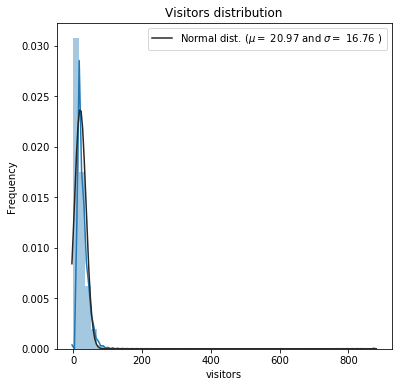

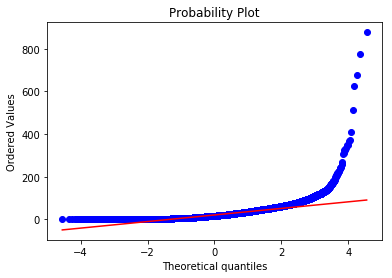

In [13]:
df = df_dict['air_visit_data'].dropna()
f, ax = plt.subplots(figsize=(6,6))
sns.distplot(df['visitors'], fit=norm)

(mu, sigma) = norm.fit(df['visitors'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Visitors distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['visitors'], plot=plt)
plt.show()

The distribution is slightly skewed and it seems that some outliers exist in the data. So, first let's try to spot ouliers comparing the number of visitors in each day to the mean of number of visitors of the same day of week.

### Outliers

In [14]:
df_visit = df_dict['air_visit_data'].merge(df_dict['date_info'], left_on='visit_date' , right_on='calendar_date', how='inner')
df_visit.drop('calendar_date', inplace=True, axis=1)
df_mean = df_visit.groupby(by=['air_store_id','day_of_week'], as_index=False)['visitors'].mean()
df_mean = df_mean.rename(columns={'visitors': 'mean_visitors'})
df_visit_mean = df_visit.merge(df_mean, on=['air_store_id', 'day_of_week'], how='inner')
df_visit_mean = df_visit_mean.sort_values('visit_date')

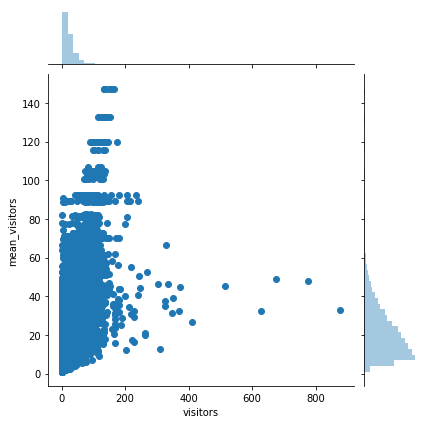

In [15]:
sns.jointplot(x='visitors', y='mean_visitors', data=df_visit_mean)

There is no clear outliers in the data. So, we will keep all the points. Let's apply the log1p numpy function to the target.


 mu = 2.80 and sigma = 0.81



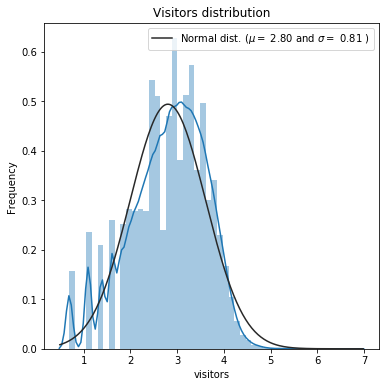

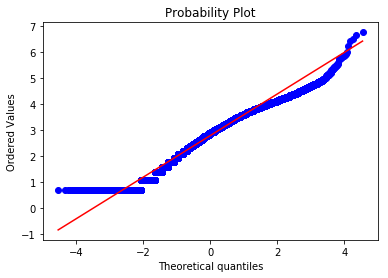

In [16]:
df_visit_mean['visitors'] = np.log1p(df_visit_mean['visitors'])
df = df_visit_mean.dropna()
f, ax = plt.subplots(figsize=(6,6))
sns.distplot(df['visitors'], fit=norm)

(mu, sigma) = norm.fit(df['visitors'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Visitors distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['visitors'], plot=plt)
plt.show()

Now the distribution is much more normally distributed. 

### Imputing missing data

Now, we are going to replace missing data for each date with the mean of the same week day.

In [17]:
import math
for i, visitors in enumerate(df_visit_mean['visitors']):
    if math.isnan(visitors):
        df_visit_mean['visitors'][i] = df_visit_mean[
                    (df_visit_mean['day_of_week'] == df_visit_mean['day_of_week'][i]) &
                    (df_visit_mean['air_store_id'] == df_visit_mean['air_store_id'][i])]['mean_visitors'].unique()[0]

C:\Users\Narjes\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Features engineering

Before we go deep in the analysis, let's check the restaurants that we should predict their number of visitors, since the number of restaurants in air and hpg sites are diffrent 829 in air and more than 4000 in hpg.

In [18]:
restaurants = df_visit_mean['air_store_id'].unique()
print(len(restaurants), "restaurants")
air_restaurants_reserve = df_dict['air_reserve']['air_store_id'].unique()
print(len(air_restaurants_reserve), "restaurants in air reserve")
hpg_restaurants_reserve = df_dict['hpg_reserve']['hpg_store_id'].unique()
print(len(hpg_restaurants_reserve), "restaurants in hpg reserve")
air_restaurants = df_dict['air_store_info']['air_store_id'].unique()
print(len(air_restaurants), "restaurants in air store info")
hpg_restaurants = df_dict['hpg_store_info']['hpg_store_id'].unique()
print(len(hpg_restaurants), "restaurants in hpg store info")

832 restaurants
314 restaurants in air reserve
13325 restaurants in hpg reserve
829 restaurants in air store info
4690 restaurants in hpg store info


We have to predict the number of visitors of 829 restaurants. In air site we have the reservation data of only 314.
So, normally the reservation data of the rest of the restaurants must be in hpg reservation data. Thus, we need the file
store_id_relation to get the ids of the restaurants on the hpg reservation data. It may be possible to have reservations from both sites for the same restaurant let's check this now if it is true.

In [19]:
hpg_restaurants_air = df_dict['hpg_reserve'].merge(df_dict['store_id_relation'], on='hpg_store_id', how='inner')
air_eq_restaurants = hpg_restaurants_air.air_store_id.unique()
rests_resv_both_platf = [rest for rest in air_restaurants_reserve if rest in air_eq_restaurants]
print(len(rests_resv_both_platf), "restaurants with reservations made on both platforms")

131 restaurants with reservations made on both platforms


For 131 restaurants, the reservation are made on air site and hpg site. Now, we are going to add the reservation data to the main dataframe we are using df_visit_mean.

In [20]:
def add_time_date_columns(df, column, date_col_name, time_col_name):
    if df[column].dtypes == 'datetime64[ns]':
        df[time_col_name] = df[column].transform(lambda x: x.time().hour)
        df[date_col_name] = df[column].transform(lambda x: x.date())
    else :
        print('Error')

add_time_date_columns(df_dict['air_reserve'], 'visit_datetime', 'visit_date', 'visit_hour')
add_time_date_columns(df_dict['hpg_reserve'], 'visit_datetime', 'visit_date', 'visit_hour')
add_time_date_columns(df_dict['air_reserve'], 'reserve_datetime', 'reserve_date', 'reserve_hour')
add_time_date_columns(df_dict['hpg_reserve'], 'reserve_datetime', 'reserve_date', 'reserve_hour')

A probably interesting feature to add to the reservation data is the diffrence in hours between the reservation time
and the visit time.

In [21]:
df_dict['air_reserve']['time_diff'] = df_dict['air_reserve']['visit_datetime'] - df_dict['air_reserve']['reserve_datetime'] 
df_dict['hpg_reserve']['time_diff'] = df_dict['hpg_reserve']['visit_datetime'] - df_dict['hpg_reserve']['reserve_datetime'] 
df_dict['air_reserve']['time_diff'] = df_dict['air_reserve']['time_diff'].apply(lambda x: (x.days * 24) + (x.seconds / 3600))
df_dict['hpg_reserve']['time_diff'] = df_dict['hpg_reserve']['time_diff'].apply(lambda x: (x.days * 24) + (x.seconds / 3600))

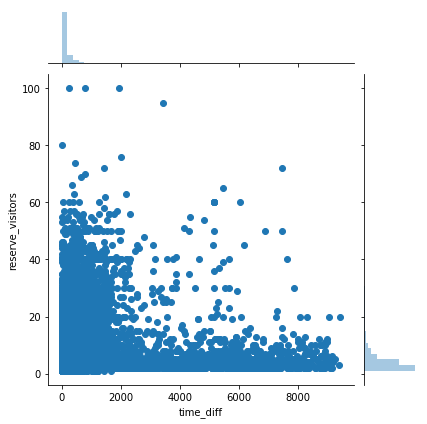

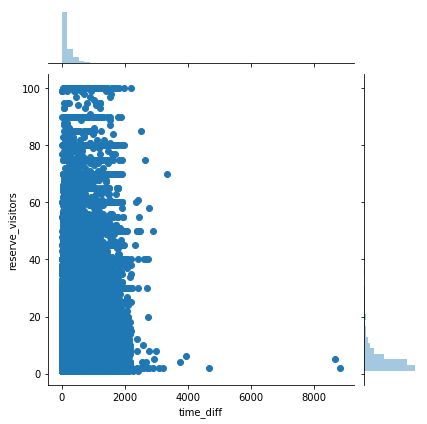

In [22]:
sns.jointplot(x='time_diff', y='reserve_visitors', data=df_dict['air_reserve'])
sns.jointplot(x='time_diff', y='reserve_visitors', data=df_dict['hpg_reserve'])

Based on these visualizations there is no correlation between the number of visitors  in the reservation and the difference between the reservation time and visit time. Let's now see if the number of visitors in each reservervation is correlated to the hour the visite.

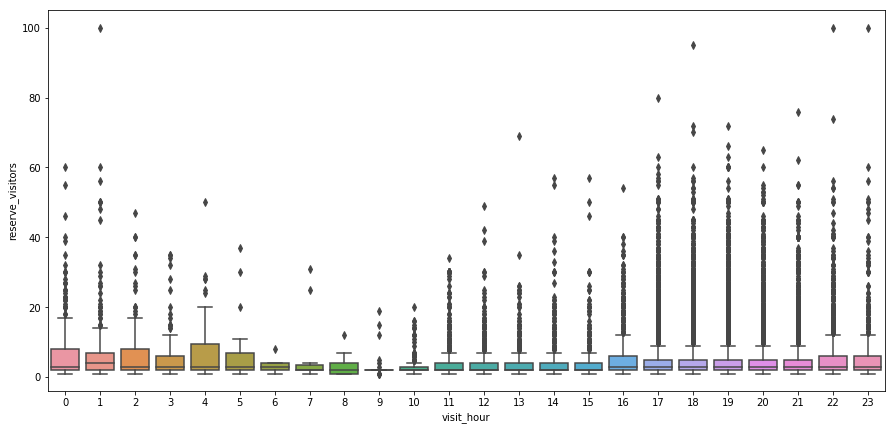

In [23]:
f, ax = plt.subplots(figsize=(15,7))
sns.boxplot(x='visit_hour', y='reserve_visitors', data=df_dict['air_reserve'])

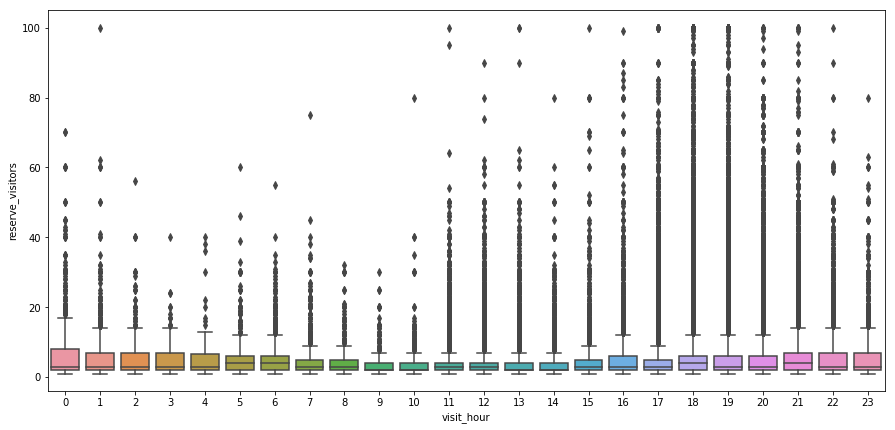

In [24]:
f, ax = plt.subplots(figsize=(15,7))
sns.boxplot(x='visit_hour', y='reserve_visitors', data=df_dict['hpg_reserve'])

In the two reservation datasets, there is an association between the visit hour and the number of visitors : a curve association. Thus, we can use the median of the visit hour in each day as new feature.

In [25]:
df_dict['air_reserve'].drop(['visit_datetime', 'reserve_datetime'], inplace=True, axis=1)
df_dict['hpg_reserve'].drop(['visit_datetime', 'reserve_datetime'], inplace=True, axis=1)

In [26]:
def reserve_features(df, col):
    df_sum = df.groupby(by=[col,'visit_date'], as_index=False)['reserve_visitors'].sum()
    df_median = df.groupby(by=[col,'visit_date'], 
                        as_index=False)['visit_hour', 'time_diff','reserve_visitors'].median().rename(
                        columns={'visit_hour':'visit_hour_median', 'time_diff':'time_diff_median',
                                                         'reserve_visitors':'reserve_visitors_median'})
    return df_sum.merge(df_median, on=[col,'visit_date'], how='inner')

air_feat_df = reserve_features(df_dict['air_reserve'], 'air_store_id')
hpg_feat_df = reserve_features(df_dict['hpg_reserve'], 'hpg_store_id')
df_visit_mean['visit_date'] = df_visit_mean['visit_date'].transform(lambda x: x.date())

In [27]:
main_df = df_visit_mean.merge(air_feat_df, on=['air_store_id', 'visit_date'], how='left')

Now, we have to use the mapping of air ids and hpg ids to add the hpg reservation data.

In [28]:
hpg_feat_df = hpg_feat_df.merge(df_dict['store_id_relation'], on='hpg_store_id', how='inner')
hpg_feat_df.drop('hpg_store_id', inplace=True, axis=1)

In [29]:
main_df = main_df.merge(hpg_feat_df, on=['air_store_id','visit_date'], how='outer')

## Machine learning models

### Baseline model

### Advanced models

### Stacking model